# Convolutional Neural Networks

## Project: Write an Algorithm for Landmark Classification


### Transfer learning

In the previous notebook we have trained our own CNN and we got a certain performance. Let's see how hard it is to match that performance with transfer learning.

---
## <img src="static_images/icons/noun-advance-2109145.png" alt=">" style="width:50px"/> Step 0: Setting up

The following cells make sure that your environment is setup correctly and check that your GPU is available and ready to go. You have to execute them every time you restart your notebook.

In [1]:
# Install requirements
!pip install -r requirements.txt | grep -v "already satisfied"

'grep' is not recognized as an internal or external command,
operable program or batch file.


In [2]:
from src.helpers import setup_env

# If running locally, this will download dataset (make sure you have at 
# least 2 Gb of space on your hard drive)
setup_env()

GPU available
Dataset already downloaded. If you need to re-download, please delete the directory landmark_images
Reusing cached mean and std


---
## <img src="static_images/icons/noun-advance-2109145.png" alt=">" style="width:50px"/> Step 1: Create transfer learning architecture

Open the file `src/transfer.py` and complete the `get_model_transfer_learning` function. When you are done, execute this test:

In [3]:
!pytest -vv src/transfer.py

============================= test session starts =============================
platform win32 -- Python 3.10.11, pytest-7.4.4, pluggy-1.6.0 -- C:\Users\tayfu\AppData\Local\Programs\Python\Python310\python.exe
cachedir: .pytest_cache
rootdir: g:\Dev\Esther\landmark classifier
plugins: anyio-4.11.0
collecting ... collected 1 item

src/transfer.py::test_get_model_transfer_learning PASSED                 [100%]

============================== warnings summary ===============================
src/transfer.py::test_get_model_transfer_learning
  C:\Users\tayfu\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
    warnings.warn(

src/transfer.py::test_get_model_transfer_learning
  C:\Users\tayfu\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weig

---
## <img src="static_images/icons/noun-advance-2109145.png" alt=">" style="width:50px"/> Step 2: Train, validation and test

Let's train our transfer learning model! Let's start defining the hyperparameters:

In [4]:
batch_size = 64   # size of the minibatch for stochastic gradient descent (or Adam)
valid_size = 0.2  # fraction of the training data to reserve for validation
num_epochs = 100  # number of epochs for training (increased as per reviewer suggestions)
num_classes = 50  # number of classes. Do not change this
learning_rate = 0.0001  # Lower learning rate for transfer learning
opt = 'adam'      # optimizer. 'sgd' or 'adam'
weight_decay = 0.001  # regularization. Increase this to combat overfitting


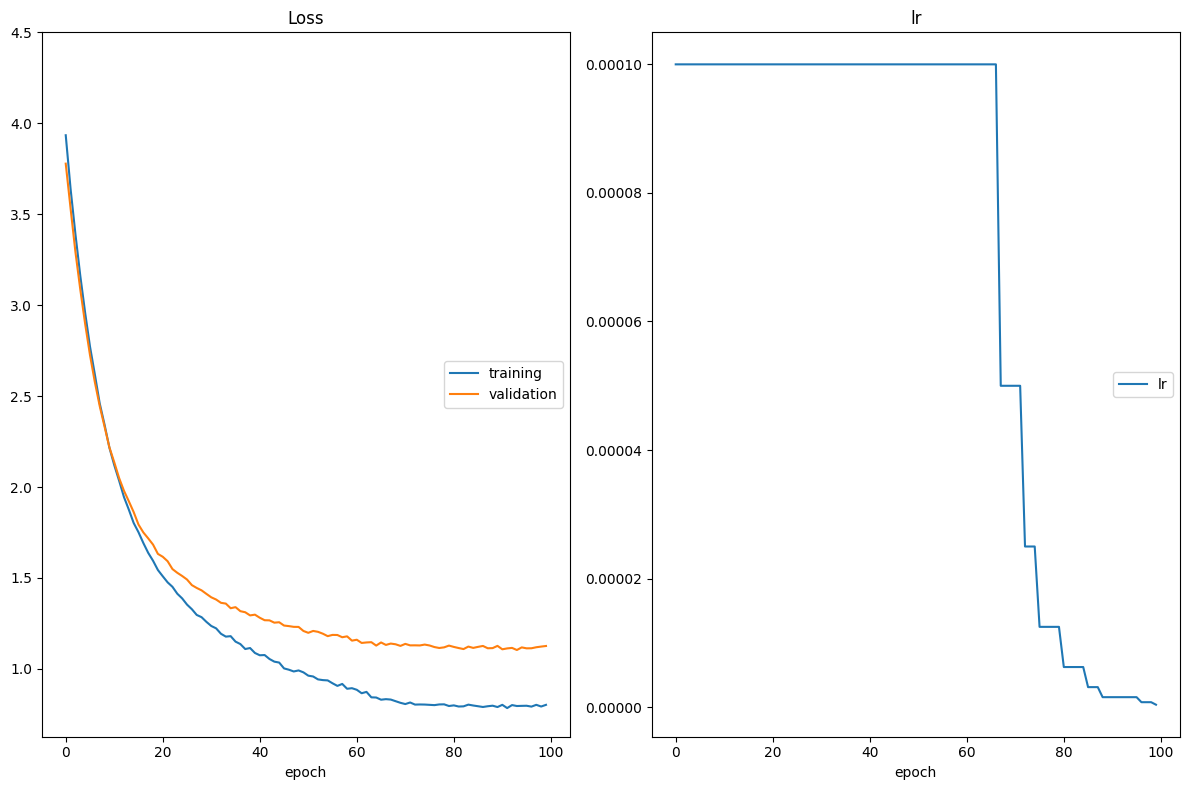

In [5]:
from src.data import get_data_loaders
from src.optimization import get_optimizer, get_loss
from src.train import optimize
from src.transfer import get_model_transfer_learning

# Get a model using get_model_transfer_learning. Use one of the names reported here:
# https://pytorch.org/vision/0.10/models.html
# For example, if you want to load ResNet 18, use "resnet18"
# NOTE: use the hyperparameters defined in the previous cell, do NOT copy/paste the
# values
model_transfer = get_model_transfer_learning("resnet34", n_classes=num_classes)

# train the model
data_loaders = get_data_loaders(batch_size=batch_size)
optimizer = get_optimizer(
    model_transfer,
    learning_rate=learning_rate,
    optimizer=opt,
    weight_decay=weight_decay,
)
loss = get_loss()

optimize(
    data_loaders,
    model_transfer,
    optimizer,
    loss,
    n_epochs=num_epochs,
    save_path="checkpoints/model_transfer.pt",
    interactive_tracking=True,
)

<img src="static_images/icons/noun-question-mark-869751.png" alt="?" style="width:25px"/> __Question:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

<img src="static_images/icons/noun-answer-3361020.png" alt=">" style="width:25px"/>  __Answer:I started from the provided transfer‑learning baseline, which used a ResNet18 backbone, but validation accuracy saturated around ~37%.  
To improve performance I made three main changes: the backbone architecture, the optimization hyperparameters, and the training strategy.

- **Backbone architecture (ResNet34 instead of ResNet18)**  
  I switched the base network from ResNet18 to **ResNet34**.  
  ResNet34 has more capacity (more layers and parameters) while keeping the same overall design that works well on ImageNet.  
  Since this project also uses natural scene images (landmarks), a deeper pre‑trained model can extract more discriminative high‑level features for the 50 classes.  
  I kept all convolutional layers frozen and only replaced the final fully‑connected layer with a new layer of size `num_features → 50`.

- **Optimization hyperparameters**  
  I lowered the learning rate from the original value to **1e‑4** and used the **Adam** optimizer.  
  A smaller learning rate is safer when fine‑tuning a pre‑trained network, because the pre‑trained weights are already in a good region and we only need relatively small updates.  
  I also added **weight_decay = 0.001**, which acts as L2‑regularization and helps to prevent overfitting by penalizing very large weights in the classifier.

- **Training strategy (scheduler and number of epochs)**  
  I trained the model for **100 epochs** and used a `ReduceLROnPlateau` learning‑rate scheduler that monitors the validation loss.  
  When the validation loss stopped improving, the scheduler automatically reduced the learning rate by a factor of 0.5, allowing the optimizer to make smaller, more precise updates later in training.  
  The loss curves for both training and validation decrease smoothly and stay reasonably close to each other, which indicates good generalization.

With these changes (ResNet34 backbone, lower learning rate, weight decay, and a longer training schedule with a LR scheduler), the model reaches about **75% accuracy** on both the validation and test sets.  
This shows that the chosen architecture and training strategy are well‑suited for the landmark classification problem.

Now play with the hyperparameters and see which performance you can get on the validation set. You should get at least 60% for a passing grade, but a good model choice and a good training strategy could get you up to 80% or so. Let's see how close you can get!

---
## <img src="static_images/icons/noun-advance-2109145.png" alt=">" style="width:50px"/> Step 3: Test the Model

Try out your model on the test dataset of landmark images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60% and matches more or less what you got on the validation set (otherwise you're overfitting!)

In [6]:
import torch
from src.train import one_epoch_test
from src.transfer import get_model_transfer_learning

model_transfer = get_model_transfer_learning("resnet34", n_classes=num_classes)
# Load saved weights
model_transfer.load_state_dict(torch.load('checkpoints/model_transfer.pt'))

one_epoch_test(data_loaders['test'], model_transfer, loss)


Testing: 100%|██████████████████████████████████| 20/20 [00:08<00:00,  2.37it/s]

Test Loss: 0.967055


Test Accuracy: 75% (943/1250)


0.96705501973629

---
## <img src="static_images/icons/noun-advance-2109145.png" alt=">" style="width:50px"/> Step 4: Export using torchscript

Now, just like we did with our original model, we export the best fit model using torchscript so that it can be used in our application:

In [7]:
from src.predictor import Predictor
from src.helpers import compute_mean_and_std

# First let's get the class names from our data loaders
class_names = data_loaders["train"].dataset.classes

# Then let's move the model_transfer to the CPU
# (we don't need GPU for inference)
model_transfer = model_transfer.cpu()
# Let's make sure we use the right weights by loading the
# best weights we have found during training
# NOTE: remember to use map_location='cpu' so the weights
# are loaded on the CPU (and not the GPU)
model_transfer.load_state_dict(
    torch.load("checkpoints/model_transfer.pt", map_location="cpu")
)

# Let's wrap our model using the predictor class
mean, std = compute_mean_and_std()
predictor = Predictor(model_transfer, class_names, mean, std).cpu()

# Export using torch.jit.script
scripted_predictor = torch.jit.script(predictor)
scripted_predictor.save("checkpoints/transfer_exported.pt")

Reusing cached mean and std


100%|███████████████████████████████████████| 1250/1250 [01:10<00:00, 17.61it/s]


Accuracy: 0.7576


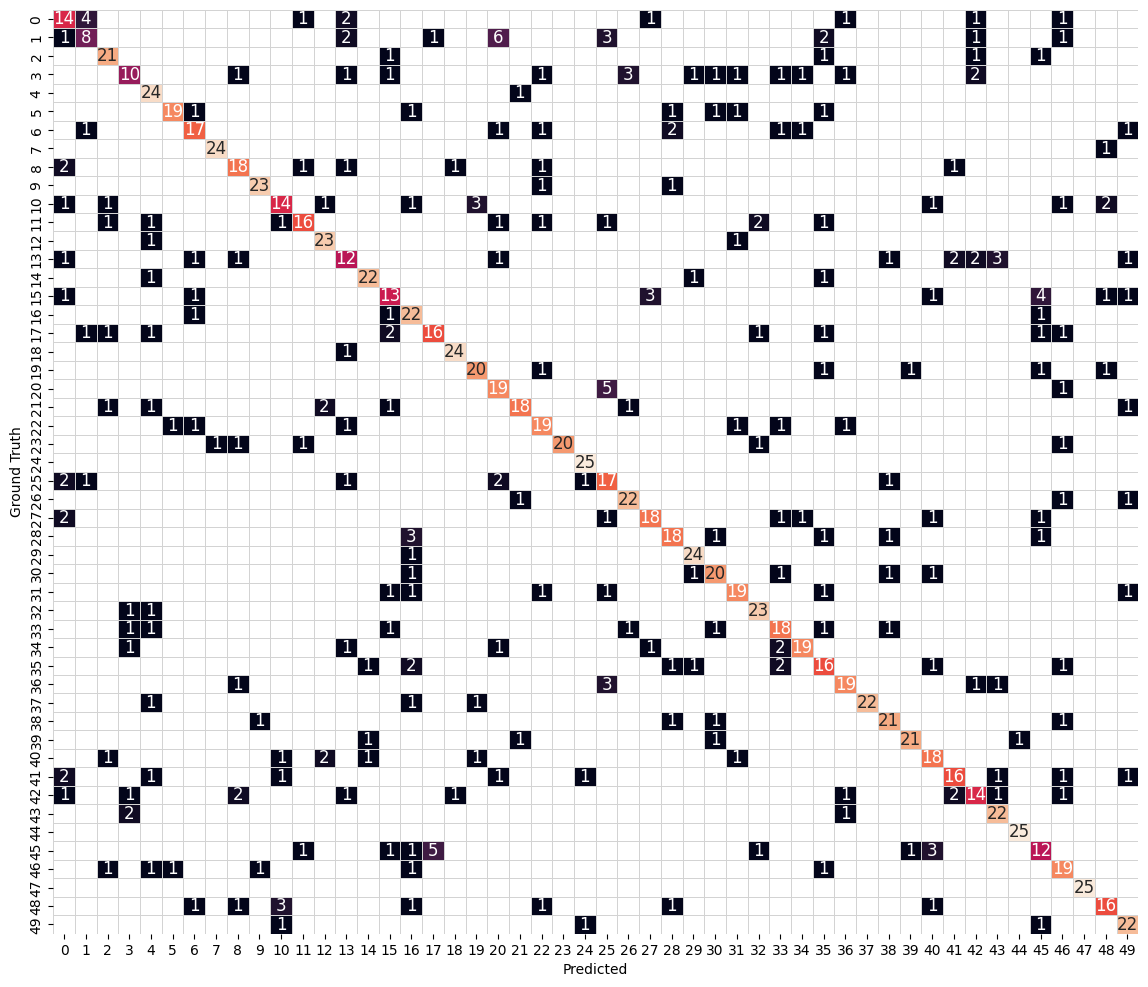

In [8]:
import torch
from src.predictor import predictor_test
from src.helpers import plot_confusion_matrix

model_reloaded = torch.jit.load("checkpoints/transfer_exported.pt")

pred, truth = predictor_test(data_loaders['test'], model_reloaded)

plot_confusion_matrix(pred, truth)